In [2]:
%cd ..

/root/huy/BrainSegmentation


In [29]:
import os
from pprint import pprint
import mlflow.pytorch
os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/huytrnq/BrainSegmentation.mlflow"
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from utils.loss import DiceLoss, DiceCrossEntropyLoss
from utils.dataset import BrainMRISliceDataset

from utils.utils import train, validate, evaluate_segmentation
from utils.predict import Predictor
from utils.metric import MetricsMonitor, dice_coefficient, dice_score_3d, hausdorff_distance, average_volumetric_difference

from utils.vis import plot_images
from utils.transforms import RobustZNormalization

## Constants

In [4]:
ROOT_DIR = './Data/'
BATCH_SIZE = 16
NUM_CLASSES = 4
EPOCHS = 300
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 0
LR = 0.01
N_TEST = 5

## Transforms

In [5]:
train_transform = A.Compose([
    # Normalize and convert to tensors
    A.Normalize(mean=(0,), std=(1,), max_pixel_value=1.0, p=1.0),
    RobustZNormalization(),
    ToTensorV2()
], additional_targets={'mask': 'mask'})  # Include mask augmentation

test_transform = A.Compose([
        A.Normalize(mean=(0,), std=(1,), max_pixel_value=1.0, p=1.0),
        RobustZNormalization(),
        ToTensorV2()
], additional_targets={'mask': 'mask'})

In [6]:
train_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'train'), slice_axis=2, transform=train_transform, cache=True, ignore_background=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, cache=True, ignore_background=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

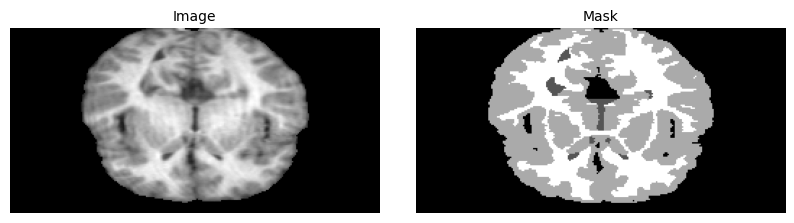

In [7]:
image, mask, volume_idx, slice_idx = train_dataset[129]


plot_images([image.permute(2, 1, 0).numpy(), mask.permute(2, 1, 0).numpy()] , ['Image', 'Mask'], cols=2, figsize=(10, 5))

## Models

In [18]:
model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=NUM_CLASSES,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)

## Loss & Optimizer

In [19]:
criterion = DiceCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

## Training

In [20]:
# Monitors
train_monitor = MetricsMonitor(metrics=["loss", "dice_score"])
val_monitor = MetricsMonitor(
    metrics=["loss", "dice_score"], patience=5, mode="max"
)
test_monitor = MetricsMonitor(metrics=["loss", "dice_score"])

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    train(model, train_loader, criterion, optimizer, DEVICE, train_monitor)
    scheduler.step()
    validate(model, val_loader, criterion, DEVICE, val_monitor)

In [ ]:
## Export Model
torch.save(model.state_dict(), "model.pth")

## Predict

### Load model

In [17]:
logged_model = 'runs:/b825a297281a465ea908e1364f6074d6/model'

# Load the model
model = mlflow.pytorch.load_model(logged_model, map_location=DEVICE)

In [18]:
predictions = []
labels = []
volume_idxs = []
slice_idxs = []
meta_data = val_dataset.metadata

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks, volume_idx, slice_idx) in enumerate(val_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        predictions.append(outputs)
        labels.append(masks)
        volume_idxs.extend(volume_idx.numpy().tolist())
        slice_idxs.extend(slice_idx.numpy().tolist())
        
predictions = torch.cat(predictions, dim=0).detach().cpu()
labels = torch.cat(labels, dim=0).squeeze(1).long().detach().cpu()
dice_scores = dice_coefficient(predictions, labels, num_classes=4)
print(dice_scores)
print(f"Dice Score: {np.mean(dice_scores)}")

[0.9955854415893555, 0.8991853594779968, 0.8881125450134277, 0.8790041208267212]
Dice Score: 0.9154718667268753


In [10]:
predictions = torch.softmax(predictions.float(), dim=1).cpu().numpy()
predictions = np.argmax(predictions, axis=1)

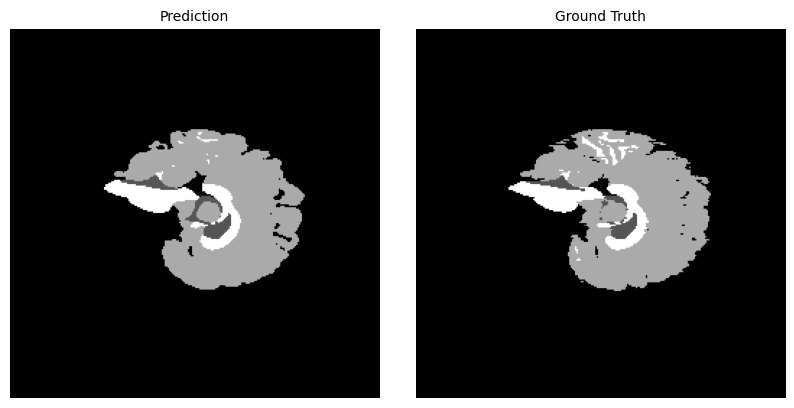

In [11]:
plot_images([predictions[129, :, :], labels[129, :, :].cpu().numpy()], ["Prediction", "Ground Truth"], cols=2)

## Ensemble

### Axial

In [11]:
axial_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=0, transform=test_transform, cache=True, ignore_background=False)
axial_loader = DataLoader(axial_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
axial_labels = torch.cat([mask for _, mask, _, _ in axial_loader], dim=0).squeeze(1).reshape(N_TEST, -1, 128, 256)

In [32]:
axial_predictor = Predictor(mlflow_model_uri="runs:/2e5316301c8c4867a4751a2172da694a/model", device=DEVICE)
axial_probs = axial_predictor.predice_slices(axial_loader, proba=True, plane='axial')

In [33]:
axial_predictions = torch.argmax(axial_probs, axis=1)
axial_r_dict = evaluate_segmentation(axial_predictions, axial_labels, NUM_CLASSES, include_background=True)

Dice scores: {0: 0.9969640970230103, 1: 0.8967788815498352, 2: 0.9238726496696472, 3: 0.9125249981880188}
Mean Dice score: 0.9110588431358337
Hausdorff Distances: {0: 17.467090606689453, 1: 12.821916580200195, 2: 8.240922927856445, 3: 7.871580600738525}
Mean Hausdorff Distance: 9.644806702931723
Average Volumetric Differences: {0: 0.0017159569841782903, 1: 0.0335448057093108, 2: 0.004572877609627762, 3: 0.0462915478879975}
Mean Average Volumetric Difference: 0.028136410402312018


### Coronal

In [14]:
coronal_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=1, transform=test_transform, cache=True, ignore_background=False)
coronal_loader = DataLoader(coronal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
coronal_labels = torch.cat([mask for _, mask, _, _ in coronal_loader], dim=0).squeeze(1).reshape(N_TEST, -1, 256, 256).permute(0, 2, 1, 3)

In [30]:
coronal_predictor = Predictor(mlflow_model_uri="runs:/77475ce587064b2aaa785000443650d3/model", device=DEVICE)
coronal_probs = coronal_predictor.predice_slices(coronal_loader, proba=True, plane='coronal')

In [31]:
coronal_predictions = torch.argmax(coronal_probs, axis=1)
coronal_r_dict = evaluate_segmentation(coronal_predictions, coronal_labels, NUM_CLASSES, include_background=True)

Dice scores: {0: 0.9965816736221313, 1: 0.7293354272842407, 2: 0.904605507850647, 3: 0.9066578149795532}
Mean Dice score: 0.846866250038147
Hausdorff Distances: {0: 21.638879776000977, 1: 20.100448608398438, 2: 17.90908432006836, 3: 8.936361312866211}
Mean Hausdorff Distance: 15.64863141377767
Average Volumetric Differences: {0: 0.0014662832341110956, 1: 0.15800951625485055, 2: 0.014518460366070352, 3: 0.005357404794200518}
Mean Average Volumetric Difference: 0.05929512713837381


### Sagittal

In [17]:
sagittal_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, cache=True, ignore_background=False)
sagittal_loader = DataLoader(sagittal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
sagittal_labels = torch.cat([mask for _, mask, _, _ in sagittal_loader], dim=0).squeeze(1).reshape(N_TEST, -1, 256, 128).permute(0, 2, 3, 1)

In [34]:
sagittal_predictor = Predictor(mlflow_model_uri="runs:/e97171b039724101a649b38d9ad15466/model", device=DEVICE)
sagittal_probs = sagittal_predictor.predice_slices(sagittal_loader, proba=True, plane='sagittal')

In [35]:
sagittal_predictions = torch.argmax(sagittal_probs, axis=1)
sagittal_r_dict = evaluate_segmentation(sagittal_predictions, sagittal_labels, NUM_CLASSES, include_background=True)

Dice scores: {0: 0.996666431427002, 1: 0.9014352560043335, 2: 0.9241362810134888, 3: 0.9228813052177429}
Mean Dice score: 0.9161509474118551
Hausdorff Distances: {0: 18.363765716552734, 1: 13.291958808898926, 2: 13.313158988952637, 3: 12.365564346313477}
Mean Hausdorff Distance: 12.990227381388346
Average Volumetric Differences: {0: 0.00208673685209417, 1: 0.02767644726371033, 2: 0.016348179469251843, 3: 0.011874073981415455}
Mean Average Volumetric Difference: 0.018632900238125878


### Ensemble

In [20]:
ensemble_probs = (axial_probs + coronal_probs + sagittal_probs) / 3
ensemble_predictions = torch.argmax(ensemble_probs, dim=1)
labels = axial_labels

In [21]:
ensemble_r_dict = evaluate_segmentation(ensemble_predictions, labels, NUM_CLASSES, include_background=True)

Dice scores: {0: 0.9975441098213196, 1: 0.921237587928772, 2: 0.94354248046875, 3: 0.9407326579093933}
Mean Dice score: 0.9351709087689718
Hausdorff Distances: {0: 17.401016235351562, 1: 11.642467498779297, 2: 9.039227485656738, 3: 7.969277858734131}
Mean Hausdorff Distance: 9.550324281056723
Average Volumetric Differences: {0: 0.00047002074218998864, 1: 0.009106529209501633, 2: 0.004209887697509483, 3: 0.000958567810996718}
Mean Average Volumetric Difference: 0.004758328239335945
